# Influence of Skin Curvature on Wingbox Optimization with Nonlinear Structural Stability Constraints

This notebook shows how to produce the figures published in the paper titled _Influence of Skin Curvature on Wingbox Optimization with Nonlinear Structural Stability Constraints_, presented at the the 34th Congress of the International Council of the Aeronautical Sciences (ICAS) in September 2024 and authored by Francesco M. A. Mitrotta, Alberto Pirrera, Terence Macquart, Jonathan E. Cooper, Alex Pereira do Prado and Pedro Higino Cabral.

* [The CRM-like box beam model](#model)
* [Influence of skin curvature](#skin-curvature)
    * [Comparison of the initial structures](#initial)
    * [Comparison of the linearly optimized structures](#linear)
    * [Comparison of the nonlinearly optimized structures](#nonlinear)
* [Appendix](#appendix)

In [1]:
import os  # package for interacting with the operating system
import matplotlib.pyplot as plt  # package for creating figures and plots
from matplotlib.lines import Line2D  # class holding the list of markers
import tol_colors as tc  # package for colorblind-friendly colors
import numpy as np  # package for scientific computing

# Define name of directory where to find the analyses
analysis_directory_name = "22_Optimization_of_the_CRM-like_Box_Beam_with_Curved_Skin"
ANALYSIS_DIRECTORY_PATH = os.path.join(os.getcwd(), "analyses", analysis_directory_name)

# Define name of directory where to save figures
figures_directory_name = "ICAS_2024"
FIGURES_DIRECTORY_PATH = os.path.join(os.getcwd(), "analyses", figures_directory_name)

# Define default figure parameters
TEXTWIDTH_INCHES = 6.691881  # paper textwidth in inches
FIG_WIDTH_INCHES = TEXTWIDTH_INCHES*.5
FIG_HEIGHT_INCHES = FIG_WIDTH_INCHES*(4.8/6.4)  # default figure height in inches
DEFAULT_FONT_SIZE = 10  # default font size of figures (normalsize in LaTeX)
DEFAULT_MARKER_SIZE = 3  # default marker size of lines
plt.rcParams.update({
    'figure.dpi': 120,  # default figure dpi
    'text.usetex': True,  # use LaTeX to render text
    'font.family': 'sans-serif',  # use sans-serif font family
    'font.sans-serif': 'Helvetica',  # use Helvetica
    'font.size': DEFAULT_FONT_SIZE,  # default font size of figures
    'mathtext.fontset': 'custom',  # use custom font settings for math
    'mathtext.rm': 'Times New Roman',  # use Times New Roman for roman math text
    'mathtext.it': 'Times New Roman:italic',  # use Times New Roman italic for italic math text
    'mathtext.bf': 'Times New Roman:bold',  # use Times New Roman bold for bold math text
    'lines.markersize': DEFAULT_MARKER_SIZE  # set default marker size of lines
})

# Define default colors and markers
MARKERS = list(Line2D.markers.keys())[2:]  # list of marker characters
plt.rc('axes', prop_cycle=plt.cycler('color', list(tc.tol_cset('bright'))))  # set default color cycle to TOL bright
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']  # retrieve list with succession of standard matplotlib colors
UNSTABLE_COLOR = COLORS[1]  # red
del COLORS[1]  # delete green and red from list of colors
COLORS[1], COLORS[2] = COLORS[2], COLORS[1]

# Define default print options for numpy
np.set_printoptions(precision=1, suppress=True)

# Define constant variables for the analyses
L = 29.38e3  # [mm] box beam length
W = 3.41e3   # [mm] box beam width
H = .77e3    # [mm] box beam height
FIRST_SUBCASE_ID = 1  # id of first subcase
SECOND_SUBCASE_ID = 2  # id of second subcase
Z_COMPONENT_INDEX = 2  # index of z-component in vector of displacements

# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis="y", which="major", pad=25)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis="z", which="major", pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 90  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .62))  # decrease colorbar size
        colorbar.ax.set_position(colorbar.ax.get_position().translated(-.07, .18))  # move colorbar upwards

## The CRM-like box beam model <a name="model"></a>

***



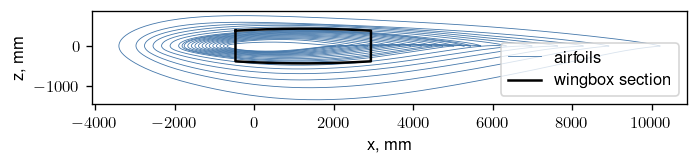

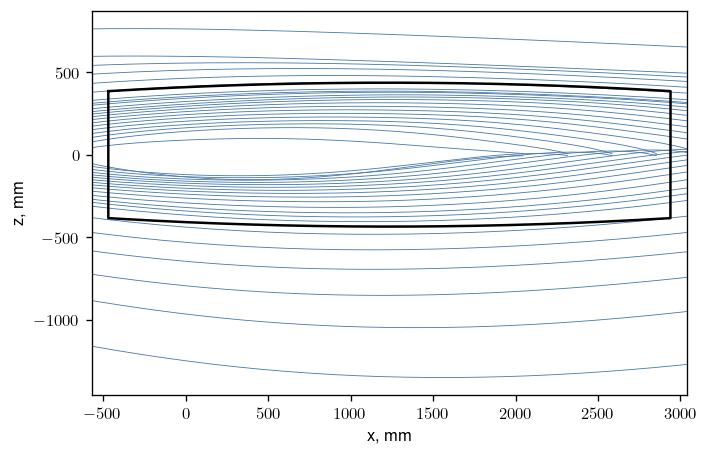

In [2]:
from resources import box_beam_utils

# Airfoil chord data taken from Taylor & Hunsaker (2021)
airfoil_chord_data = np.array([  # [xi, chord] pairs
    [0.00, 13.6161],
    [0.10, 11.8976],
    [0.15, 11.0384],
    [0.20, 10.1790],
    [0.25,  9.3197],
    [0.30,  8.4604],
    [0.35,  7.6010],
    [0.37,  7.2573],
    [0.40,  7.0416],
    [0.45,  6.6821],
    [0.50,  6.3226],
    [0.55,  5.9631],
    [0.60,  5.6035],
    [0.65,  5.2440],
    [0.70,  4.8845],
    [0.75,  4.5250],
    [0.80,  4.1654],
    [0.85,  3.8059],
    [0.90,  3.4464],
    [0.95,  3.0869],
    [1.00,  2.7274]
])


# Define a function to load the airfoil coordinates from a given file
def load_airfoil_coordinates(file_path):
    """
    Load airfoil coordinates from a given text file.

    Parameters:
    file_path (str): The path to the file containing the airfoil coordinates.

    Returns:
    numpy.ndarray: The airfoil coordinates loaded from the file.
    """
    # Check if the file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    # Load the data from the file
    data = np.loadtxt(file_path, dtype=float)
    return data


# Define a function to position the airfoils according to the chord
def position_airfoil(coordinates, chord):
    """
    Position the airfoil according to the chord.

    Parameters:
    coordinates (numpy.ndarray): The airfoil coordinates.
    chord (float): The chord length of the airfoil.

    Returns:
    numpy.ndarray: The positioned airfoil coordinates.
    """
    # Scale the coordinates based on the chord
    scaled_coords = coordinates * chord
    # Shift the airfoil so that the quarter-chord point is at x=0
    scaled_coords[:, 0] += - 0.25 * chord

    return scaled_coords


# Define a function to plot the airfoils with given airfoil data and location data
def plot_airfoils(axes):
    """
    Plot all airfoils on a single graph.

    Parameters:
    airfoil_data (list): A list of numpy arrays containing airfoil coordinates.
    airfoil_chord_data (numpy.ndarray): Array containing the chord for each airfoil position.
    """
    
    # Path to the directory containing airfoil data files
    data_directory = os.path.join(os.getcwd(), "resources", "DATA_Taylor_20201201_ALL")
    
    # Initialize an empty list to store the airfoil data
    airfoil_data = []

    # Loop through each position and load the corresponding airfoil data
    for position in airfoil_chord_data[:, 0]:
        # Construct the file name based on the given pattern
        file_name = f'uCRM-9_wr{int(position*100)}_profile.txt'
        # Construct the full file path
        file_path = os.path.join(data_directory, file_name)
        
        # Load the coordinates from the file
        try:
            airfoil_data.append(load_airfoil_coordinates(file_path))
        except Exception as e:
            print(f"An error occurred while loading data from {file_path}: {e}")
            # You might want to handle the error, skip the file, or use empty data
            # For example, here we append an empty array if the file cannot be loaded
            airfoil_data.append(np.array([]))

    for airfoil, (_, chord) in zip(airfoil_data, airfoil_chord_data):
        # Position the airfoil
        positioned_coords = position_airfoil(airfoil, chord)
        # Plot the airfoil
        axes.plot(positioned_coords[:, 0]*1e3, positioned_coords[:, 1]*1e3, color=COLORS[0], linewidth=.5)

    # Set labels and aspect ratio of the axes
    axes.set_xlabel('x, mm')
    axes.set_ylabel('z, mm')
    axes.set_aspect('equal', adjustable='box')


def plot_wingbox_section(axes, arch_height, zoom=False):
    # Calculate the arc's radius and center position based on beam geometry
    r = ((W / 2) ** 2 + arch_height ** 2) / (2 * arch_height)
    x_c = W / 2
    z_c_top = -r + arch_height + H / 2
    
    # Find the coordinates of the upper surface of the box beam section
    xz_coordinates_start = np.array([0, H/2])
    xz_coordinates_end = np.array([W, H/2])
    y = 0
    element_length = .01
    x_coordinates, _, _, z_coordinates_top = box_beam_utils.find_coordinates_along_arc(
                    x_c, z_c_top, r, xz_coordinates_start, xz_coordinates_end, y, y, element_length)
    z_coordinates_bottom = -z_coordinates_top
    
    # Create arrays of coordinates to describe the full box beam section
    x_coordinates_section = np.concatenate((x_coordinates, x_coordinates[::-1], x_coordinates[0:1]))
    z_coordinates_section = np.concatenate((z_coordinates_top, z_coordinates_bottom[::-1], z_coordinates_top[0:1]))

    # Plot the box beam section on the same graph as the airfoils
    x_offset = .47*1e3  # [mm] offset to match front and rear spar with upper and lower airfoil surface
    axes.plot(x_coordinates_section - x_offset, z_coordinates_section, 'k')
    
    # Set axes limit to zoom into the wingbox section
    if zoom:
        axes.set_xlim(np.min(x_coordinates_section - x_offset) - 100, np.max(x_coordinates_section - x_offset) + 100)


# Plot the airfoils without zoom
fig, ax = plt.subplots()
plot_airfoils(ax)
plot_wingbox_section(ax, H/15)
airfoil_line = Line2D([0], [0], linestyle='-', color=COLORS[0], linewidth=.5, label='airfoils')
wingbox_line = Line2D([0], [0], linestyle='-', color='k', label='wingbox section')
ax.legend(handles=[airfoil_line, wingbox_line])
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "Airfoils.svg"), format='svg', bbox_inches='tight', pad_inches=0)

# Plot the airfoils with zoom
fig, ax = plt.subplots()
plot_airfoils(ax)
plot_wingbox_section(ax, H/15, True)
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "AirfoilsZoom.svg"), format='svg', bbox_inches='tight', pad_inches=0)

## Influence of skin curvature <a name="skin-curvature"></a>

***

### Comparison of the initial structures <a name="initial"></a>

Compare linear buckling load.

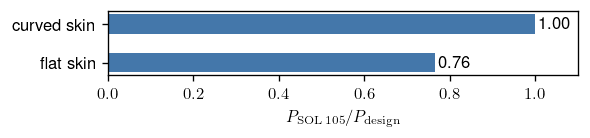

In [3]:
from pyNastran.op2.op2 import read_op2

# Initialize dictionary with names of input files
sol_105_input_name_dict = {"curved skin": "sol_105_curved_linear_opt_start",
                           "flat skin": "sol_105_flat_linear_opt_start"}

# Initialize dictionary to store OP2 objects
sol_105_op2_dict = {}

# Read linear buckling load for each analysis
buckling_load_factors = []
for key, input_name in sol_105_input_name_dict.items():
     op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2')
     sol_105_op2_dict[key] = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
     buckling_load_factors.append(sol_105_op2_dict[key].eigenvectors[SECOND_SUBCASE_ID].eigrs[0])

# Plot bar chart with linear buckling loads
fig, ax = plt.subplots(figsize=(FIG_WIDTH_INCHES*1.5, FIG_HEIGHT_INCHES/2))
y_pos = np.arange(len(sol_105_input_name_dict.keys()))  # position of bars
p = ax.barh(y_pos, buckling_load_factors, height=0.5)  # plot bars
ax.bar_label(p, padding=2, fmt="{:,.2f}")  # add labels to bars
ax.set_yticks(y_pos, labels=tuple(sol_105_input_name_dict.keys()))  # set labels of y-axis
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("$P_\mathrm{SOL\,105}/P_\mathrm{design}$")  # set label of x-axis
ax.set_xlim(right=1.1)  # set limits of x-axis

# Save figure
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "LinearBucklingBarChart.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Compare critical buckling mode.

Critical buckling mode of model with curved skin:


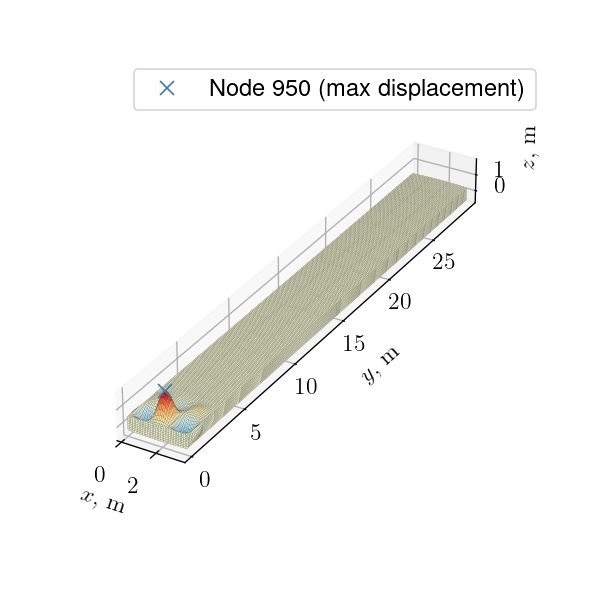

Critical buckling mode of model with flat skin:


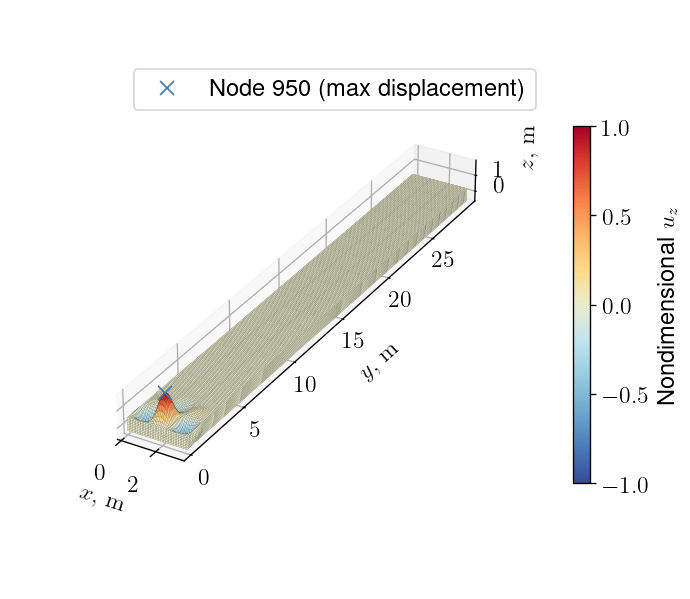

In [4]:
from resources import plot_utils

# Initialize dictionary to store root node ids
plot_node_id_dict = {}

# Define amplification factor of displacements
amplification_factor = 1.5

# Plot critical buckling mode of model with curved skin
key = "curved skin"
print(f"Critical buckling mode of model with {key}:")
clim = [-1., 1.]
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/0.7),
                     'lines.markersize': 8})
fig, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2_dict[key], subcase_id=SECOND_SUBCASE_ID, displacement_component='tz', colormap='sunset',
    length_unit='m', displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3, clim=clim)
cbar.remove()

# Plot maximum displacement node and add legend
plot_node_id_dict[key] = [plot_utils.plot_max_displacement_node(
    axes=ax, op2=sol_105_op2_dict[key], displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3)]
ax.legend(bbox_to_anchor=(.93, .92))

# Adjust plot and show it
adjust_3d_plot(ax, cbar)
plt.show()

# Save figure
BBOX_NO_COLORBAR = fig.bbox_inches.from_bounds(.8, .5, 4., 3.9)  # create bounding box for figure
label = key.title().replace(" ", "")  # label of figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"InitialBucklingMode-{label}.png"), format='png', bbox_inches=BBOX_NO_COLORBAR, pad_inches=0, dpi=500)

# Plot critical buckling mode of model with curved skin
key = "flat skin"
print(f"Critical buckling mode of model with {key}:")
fig, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2_dict[key], subcase_id=SECOND_SUBCASE_ID, displacement_component='tz', colormap='sunset',
    length_unit='m', displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3, clim=clim)

# Plot maximum displacement node and add legend
plot_node_id_dict[key] = [plot_utils.plot_max_displacement_node(
    axes=ax, op2=sol_105_op2_dict[key], displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3)]
ax.legend(bbox_to_anchor=(.93, .92))

# Adjust plot and show it
adjust_3d_plot(ax, cbar)
plt.show()

# Save figure
BBOX_COLORBAR = fig.bbox_inches.from_bounds(.8, .5, 5.2, 3.9)  # create bounding box for figure
label = key.title().replace(" ", "")  # label of figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"InitialBucklingMode-{label}.png"), format='png', bbox_inches=BBOX_COLORBAR, pad_inches=0, dpi=500)

# Reset default sizes
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE,
                     'lines.markersize': DEFAULT_MARKER_SIZE})

Compare load-displacement diagram of nonlinear analyses.

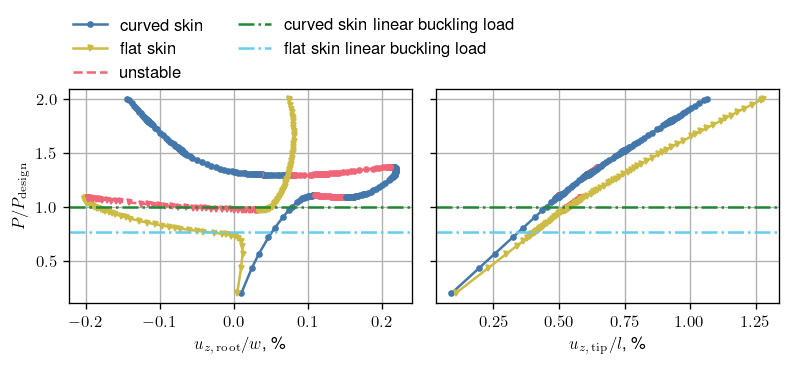

In [5]:
from resources import pynastran_utils

# Design load is equal to linear buckling load of initial structure under distributed non-follower forces
design_load = 39823.  # [N]

# Find ids of tip nodes and add to dictionary of plot nodes
tip_node_xyz = np.array([W/2, L, 0])  # tip node is taken at the center of the tip rib
for key, op2 in sol_105_op2_dict.items():
    plot_node_id_dict[key].append(np.argmin(np.linalg.norm(np.array([op2.nodes[i].xyz for i in op2.nodes]) - tip_node_xyz, axis=1)) + 1)

def plot_load_displacement_diagram(input_name_dict, max_nondimensional_load=1):
    # Create one figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(TEXTWIDTH_INCHES, FIG_HEIGHT_INCHES))
    stable_lines = []

    # Read eigenvalues, load and displacement histories and plot load-displacement diagrams
    eigenvalues_dict = {}
    sol_106_op2_dict = {}
    nondimensional_loads_dict = {}
    for count, (key, input_name) in enumerate(input_name_dict.items()):

        # Read eigenvalues
        f06_path = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.f06')  # path to .f06 file
        eigenvalues_dict[key] =pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_path)

        # Read load and displacement histories
        sol_106_op2_dict[key] = read_op2(os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2'), load_geometry=True, debug=None)
        _, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(
            op2=sol_106_op2_dict[key], node_ids=plot_node_id_dict[key])
        nondimensional_loads_dict[key] = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/design_load
        
        # Plot applied load vs root displacement
        last_plot_index = np.argmin(np.abs(nondimensional_loads_dict[key] - max_nondimensional_load)) + 1  # limit plot to applied loads less than or equal to design load
        if last_plot_index > eigenvalues_dict[key].shape[1]:
            last_plot_index -= 1
        plot_utils.plot_2d_load_displacements_stability(
            axes[0],
            displacements[plot_node_id_dict[key][0]][FIRST_SUBCASE_ID][:last_plot_index, Z_COMPONENT_INDEX]/W*100,
            nondimensional_loads_dict[key][:last_plot_index],
            eigenvalues_dict[key][:, :last_plot_index],
            MARKERS[count], COLORS[count])
        stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[count], color=COLORS[count], label=key))

        # Plot applied load vs tip displacement
        plot_utils.plot_2d_load_displacements_stability(
            axes[1],
            displacements[plot_node_id_dict[key][1]][FIRST_SUBCASE_ID][:last_plot_index, Z_COMPONENT_INDEX]/L*100,
            nondimensional_loads_dict[key][:last_plot_index],
            eigenvalues_dict[key][:, :last_plot_index],
            MARKERS[count], COLORS[count])
        
    # Return
    return fig, axes, stable_lines, eigenvalues_dict, sol_106_op2_dict, nondimensional_loads_dict

# Initialize dictionary with names of input files
input_name_dict = {"curved skin": "sol_106_33120_elements",
                   "flat skin": "sol_106_flat_initial"}

# Plot load-displacement diagrams
fig, axes, stable_lines, eigenvalues_dict, sol_106_op2_dict, nondimensional_loads_dict = plot_load_displacement_diagram(
    input_name_dict, max_nondimensional_load=2)

# Plot linear buckling load lines
linear_buckling_load_lines = [Line2D([0], [0])]*2
for count, key in enumerate(input_name_dict):
    for ax in axes:
        linear_buckling_load_lines[count] = ax.axhline(y=buckling_load_factors[count], color=COLORS[2 + count], linestyle='-.',
                                                       label=f"{key} linear buckling load")

# Create proxy artists for unstable segments
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")

# Set plot appearance for the first subplot
axes[0].set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[1].grid(visible=True)

# Save figure
plt.tight_layout()  # Ensures proper spacing between subplots
axes[0].legend(handles=stable_lines + [unstable_line] + linear_buckling_load_lines, loc="upper left",
               ncols=2, bbox_to_anchor=(-.03, 1.4), frameon=False)  # add legend after tight_layout
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "InitialLoadDisplacementDiagram.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Compare applied load at first limit point.

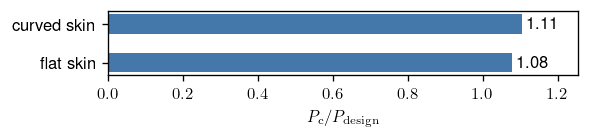


Percentage differences of limit point load of flat skin w.r.t. curved skin: -2.4%



In [6]:
def plot_limit_point_load_bar_chart(key_list, eigenvalues_dict, nondimensional_loads_dict, figure_name):
    # Find limit point load for each analysis
    first_negative_eigenvalue_index_dict = {}
    limit_point_loads = []
    for key in key_list:
        first_negative_eigenvalue_index_dict[key] = np.where(eigenvalues_dict[key][0] < 0)[0][0]  # find index of first negative eigenvalue
        limit_point_loads.append(np.mean(
            nondimensional_loads_dict[key][first_negative_eigenvalue_index_dict[key] - 1:first_negative_eigenvalue_index_dict[key] + 1]))  # calculate nondimensional applied load at limit point as the mean between the last stable and first unstable load

    # Plot bar chart with limit point loads
    fig, ax = plt.subplots(figsize=(FIG_WIDTH_INCHES*1.5, FIG_HEIGHT_INCHES/2))
    y_pos = np.arange(len(sol_105_input_name_dict.keys()))  # position of bars
    p = ax.barh(y_pos, limit_point_loads, height=0.5)  # plot bars
    ax.bar_label(p, padding=3, fmt="{:,.2f}")  # add labels to bars
    ax.set_yticks(y_pos, labels=tuple(sol_105_input_name_dict.keys()))  # set labels of y-axis
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel("$P_\mathrm{c}/P_\mathrm{design}$")  # set label of x-axis
    ax.set_xlim(right=np.max(limit_point_loads) + .15)  # set limits of x-axis

    # Save figure
    plt.tight_layout()  # Ensures proper spacing between subplots
    plt.show()
    fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, figure_name + '.svg'), format='svg', bbox_inches='tight', pad_inches=0)
    
    # Return list of limit point loads and dictionary with indices of first negative eigenvalues
    return limit_point_loads, first_negative_eigenvalue_index_dict

# Plot bar chart with limit point loads
limit_point_loads, first_negative_eigenvalue_index_dict = plot_limit_point_load_bar_chart(
    ["curved skin", "flat skin"], eigenvalues_dict, nondimensional_loads_dict, "LimitPointLoadBarChart")

# Calculate percentage differences w.r.t. distributed non-follower forces
percentage_difference = 100*(limit_point_loads[1]-limit_point_loads[0])/limit_point_loads[0]
print(f"""
Percentage differences of limit point load of flat skin w.r.t. curved skin: {percentage_difference:.1f}%
""")

Compare deformation before and after first snap of curved skin model.

Deformation before snap:


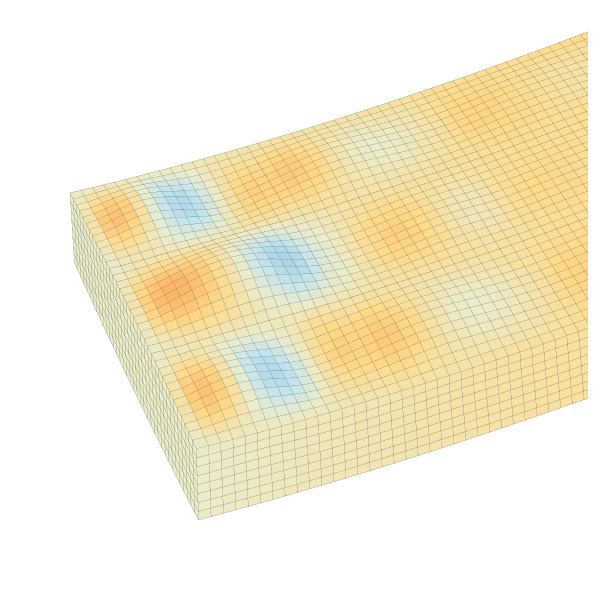

Deformation after snap


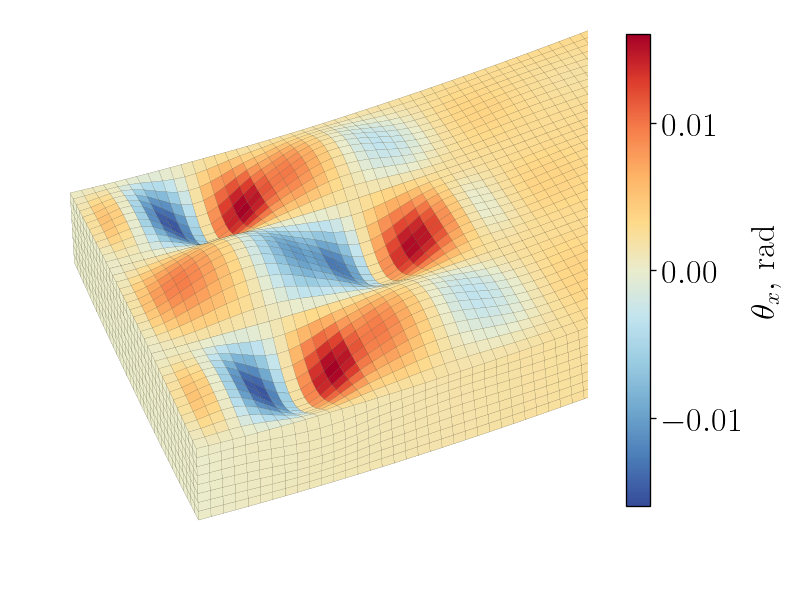

In [7]:
# Increase font size because figures are rendered side by side in the paper
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/.49)})

# Define function to zoom deformation plot to root
def zoom_to_root(axes):
    axes.set_xlim(0, W*1e-3)
    axes.set_ylim(0, 4*H*1e-3)
    axes.set_zlim(-H/2*1e-3, H*1e-3)
    axes.set_box_aspect([ub - lb for lb, ub in (getattr(axes, f"get_{a}lim")() for a in 'xyz')])
    plt.axis('off')
    axes.view_init(40, -20)

# Plot deformation just before limit point
key = "curved skin"
print("Deformation before snap:")
amplification_factor = 60  # amplification factor for displacements
clim = [-.016, .016]  # color limits for deformation plot
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=first_negative_eigenvalue_index_dict[key], displacement_component='rx',
    colormap='sunset', length_unit='m', unit_scale_factor=1e-3, displacement_amplification_factor=amplification_factor, clim=clim)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax)
cbar.remove()
zoom_to_root(ax)
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "CurvedSkinBeforeFirstSnap.svg"), format='svg', bbox_inches='tight', pad_inches=0)

# Plot deformation just after snap
skip = 10  # number of increments to skip for selection of applied load after snap
subsequent_values = nondimensional_loads_dict[key][first_negative_eigenvalue_index_dict[key] + skip:]  # consider only applied loads after snap
closest_index_in_subsequent = np.argmin(np.abs(limit_point_loads[0] - subsequent_values))  # find index of closest value to applied load at first limit point
closest_index = first_negative_eigenvalue_index_dict[key] + skip + closest_index_in_subsequent  # sum found index to index of first negative eigenvalue
print("Deformation after snap")
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=closest_index + 1, displacement_component='rx',
    colormap='sunset', length_unit='m', unit_scale_factor=1e-3, displacement_amplification_factor=amplification_factor, clim=clim)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax)
cbar.ax.set_position(cbar.ax.get_position().shrunk(1.0, .82))  # decrease colorbar size
cbar.ax.set_position(cbar.ax.get_position().translated(0, .14))  # move colorbar upwards
zoom_to_root(ax)
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "CurvedSkinAfterFirstSnap.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Compare deformation before and after second snap of curved skin model.

Deformation before snap:


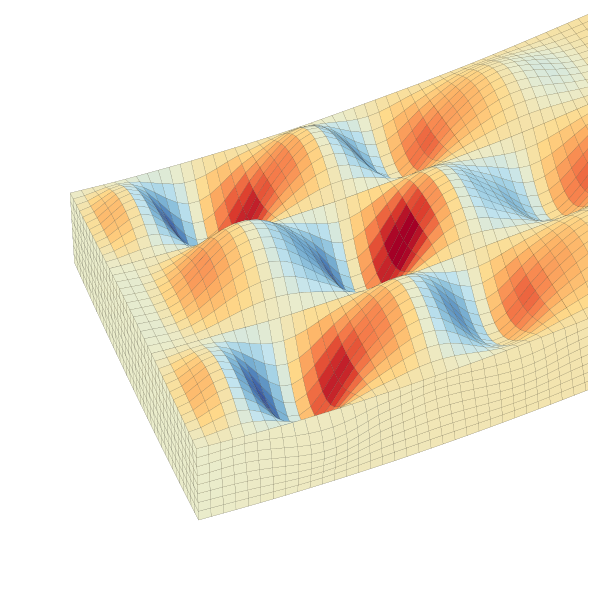

Deformation after snap


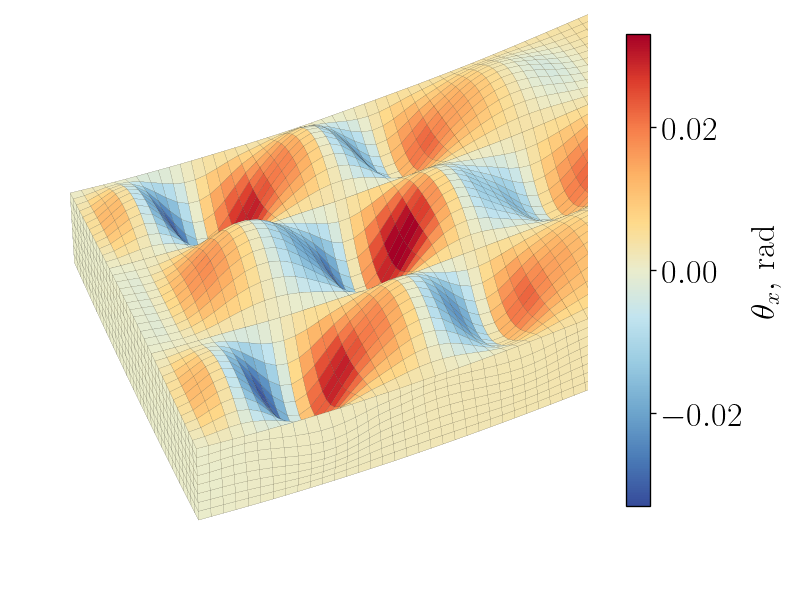

In [8]:
# Find index of second limit point load
eigenvalue_signs = np.sign(eigenvalues_dict[key][0])
positive_to_negative_changes = (eigenvalue_signs[:-1] > 0) & (eigenvalue_signs[1:] < 0)
second_limit_point_index = np.argmax(np.cumsum(positive_to_negative_changes) == 2)

# Plot deformation just before limit point
print("Deformation before snap:")
clim = [-.033, .033]  # color limits for deformation plot
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=second_limit_point_index + 1, displacement_component='rx',
    colormap='sunset', length_unit='m', unit_scale_factor=1e-3, displacement_amplification_factor=amplification_factor, clim=clim)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax)
cbar.remove()
zoom_to_root(ax)
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "CurvedSkinBeforeSecondSnap.svg"), format='svg', bbox_inches='tight', pad_inches=0)

# Plot deformation just after snap
skip = 10  # number of increments to skip for selection of applied load after snap
subsequent_values = nondimensional_loads_dict[key][second_limit_point_index + skip:]  # consider only applied loads after snap
closest_index_in_subsequent = np.argmin(np.abs(nondimensional_loads_dict[key][second_limit_point_index] - subsequent_values))  # find index of closest value to applied load at first limit point
closest_index = second_limit_point_index + skip + closest_index_in_subsequent  # sum found index to index of first negative eigenvalue
print("Deformation after snap")
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=closest_index + 1, displacement_component='rx',
    colormap='sunset', length_unit='m', unit_scale_factor=1e-3, displacement_amplification_factor=amplification_factor, clim=clim)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax)
cbar.ax.set_position(cbar.ax.get_position().shrunk(1.0, .82))  # decrease colorbar size
cbar.ax.set_position(cbar.ax.get_position().translated(0, .14))  # move colorbar upwards
zoom_to_root(ax)
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "CurvedSkinAfterSecondSnap.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Compare deformation before and after snap of flat skin model.

Deformation before snap:


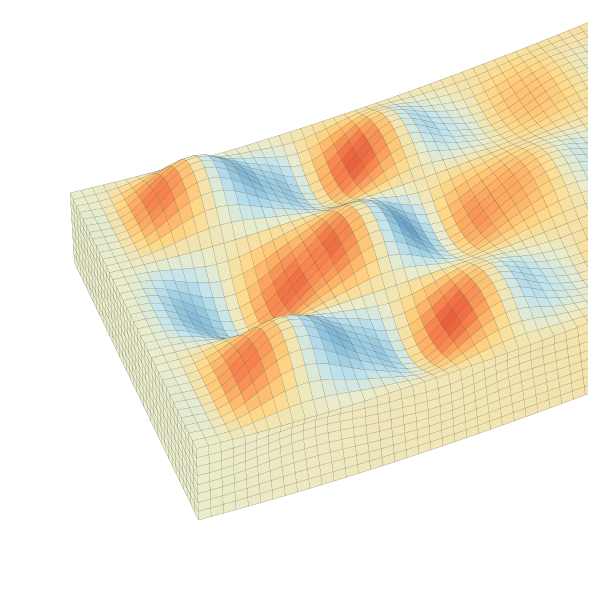

Deformation after snap


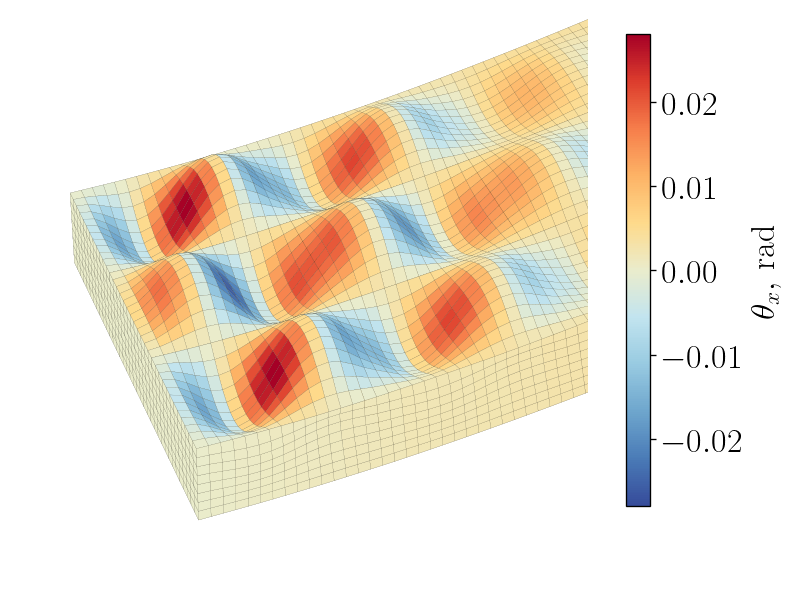

In [9]:
# Plot deformation just before limit point
key = "flat skin"
print("Deformation before snap:")
clim = [-.028, .028]  # color limits for deformation plot
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=first_negative_eigenvalue_index_dict[key], displacement_component='rx',
    colormap='sunset', length_unit='m', unit_scale_factor=1e-3, displacement_amplification_factor=amplification_factor, clim=clim)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax)
cbar.remove()
zoom_to_root(ax)
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "FlatSkinBeforeSnap.svg"), format='svg', bbox_inches='tight', pad_inches=0)

# Plot deformation just after snap
skip = 10  # number of increments to skip for selection of applied load after snap
subsequent_values = nondimensional_loads_dict[key][first_negative_eigenvalue_index_dict[key] + skip:]  # consider only applied loads after snap
closest_index_in_subsequent = np.argmin(np.abs(limit_point_loads[0] - subsequent_values))  # find index of closest value to applied load at first limit point
closest_index = first_negative_eigenvalue_index_dict[key] + skip + closest_index_in_subsequent  # sum found index to index of first negative eigenvalue
print("Deformation after snap")
fig, ax, cbar = plot_utils.plot_deformation(
    op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=closest_index + 1, displacement_component='rx',
    colormap='sunset', length_unit='m', unit_scale_factor=1e-3, displacement_amplification_factor=amplification_factor, clim=clim)  # plot buckling mode converting from mm to m
adjust_3d_plot(ax)
cbar.ax.set_position(cbar.ax.get_position().shrunk(1.0, .82))  # decrease colorbar size
cbar.ax.set_position(cbar.ax.get_position().translated(0, .14))  # move colorbar upwards
zoom_to_root(ax)
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "FlatSkinAfterSnap.svg"), format='svg', bbox_inches='tight', pad_inches=0)

# Restore default font size
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})

### Comparison of the linearly optimized structures <a name="linear"></a>

Plot history of optimization with curved skin.

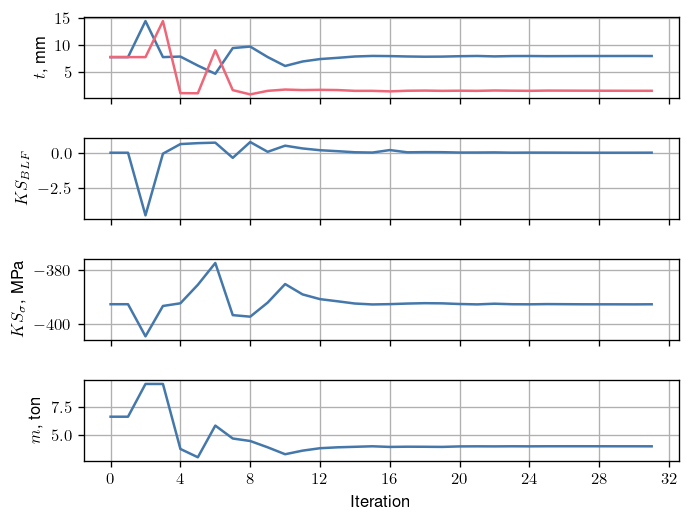

Design variables, constraints and objective at last iteration:
- interp.t_cp: [7.9 1.4]
- nastran_solver.ks_buckling: [0.]
- nastran_solver.ks_stress: [-392.8]
- nastran_solver.mass: [4.]
Mass reduction: -39.3%


In [10]:
from resources import optimization_utils

recorder_filename = "sol_105_curved_linear_opt.sql"
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, recorder_filename)
fig, curved_skin_linear_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
mass_reduction = 100*(curved_skin_linear_opt_histories['nastran_solver.mass'][-1, 0] -\
    curved_skin_linear_opt_histories['nastran_solver.mass'][0, 0])/curved_skin_linear_opt_histories['nastran_solver.mass'][0, 0]
print(f"Mass reduction: {mass_reduction:.1f}%")
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "CurvedSkinLinearOptHistory.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Plot history of optimization with flat skin.

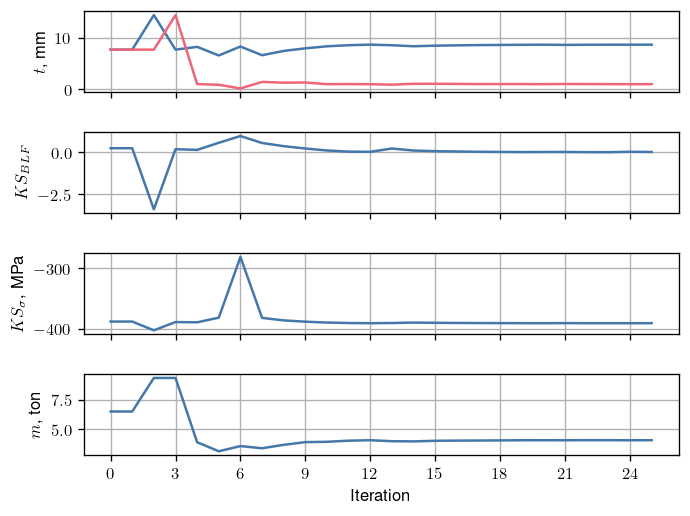

Design variables, constraints and objective at last iteration:
- interp.t_cp: [8.7 1. ]
- nastran_solver.ks_buckling: [0.]
- nastran_solver.ks_stress: [-390.6]
- nastran_solver.mass: [4.1]
Mass reduction: -37.2%


In [11]:
recorder_filename = "sol_105_flat_linear_opt.sql"
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, recorder_filename)
fig, flat_skin_linear_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)
mass_reduction = 100*(flat_skin_linear_opt_histories['nastran_solver.mass'][-1, 0] -\
    flat_skin_linear_opt_histories['nastran_solver.mass'][0, 0])/flat_skin_linear_opt_histories['nastran_solver.mass'][0, 0]
print(f"Mass reduction: {mass_reduction:.1f}%")
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "FlatSkinLinearOptHistory.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Plot bar chat of final thicknesses.

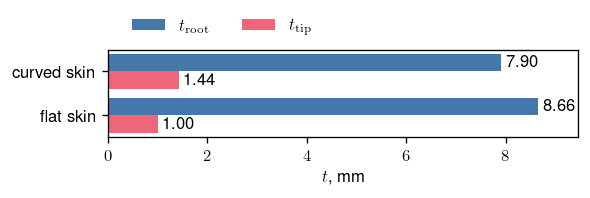

In [12]:
# Define function to plot bar chart of final thicknesses
def plot_thickness_bar_chart(curved_skin_histories, flat_skin_histories, figure_filename, iter_indices=[-1, -1]):
    # Set up data for the bar chart
    optimizations = ("curved skin", "flat skin")
    final_thicknesses = {
        "$t_\mathrm{root}$": (curved_skin_histories["interp.t_cp"][iter_indices[0], 0], flat_skin_histories["interp.t_cp"][iter_indices[1], 0]),
        "$t_\mathrm{tip}$": (curved_skin_histories["interp.t_cp"][iter_indices[0], 1], flat_skin_histories["interp.t_cp"][iter_indices[1], 1])
    }

    # Plot bar chart with final thicknesses
    y_pos = np.arange(len(optimizations))  # the label locations
    height = .4  # the height of the bars
    multiplier = .5  # multiplier to separate bars
    fig, ax = plt.subplots(figsize=(FIG_WIDTH_INCHES*1.5, FIG_HEIGHT_INCHES/1.75))  # create figure and axis
    for attribute, values in final_thicknesses.items():  # iterate over attributes and values
        offset = height * multiplier  # offset to separate bars
        rects = ax.barh(y_pos + offset, values, height, label=attribute)  # plot bars
        ax.bar_label(rects, padding=3, fmt="{:,.2f}")  # add labels to bars
        multiplier += 1.  # increase multiplier to separate bars

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("$t$, mm")
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_yticks(y_pos + height, optimizations)
    ax.set_xlim(right=max(max(v) for v in final_thicknesses.values()) + 0.8)  # set limits of x-axis

    # Save figure
    plt.tight_layout()  # ensures proper spacing between subplots
    ax.legend(bbox_to_anchor=(.02, 1.), ncols=2, frameon=False)  # add legend after tight layout
    plt.show()
    fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, figure_filename + '.svg'), format='svg', bbox_inches='tight', pad_inches=0)

# Plot bar chart with final thicknesses
figure_name = "LinearOptThicknesses"
plot_thickness_bar_chart(curved_skin_linear_opt_histories, flat_skin_linear_opt_histories, figure_name)

Plot bar chart of final masses.

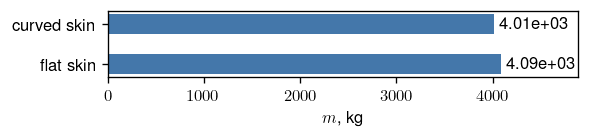

In [13]:
# Define function to plot bar chart of final thicknesses
def plot_final_mass_bar_chart(curved_skin_histories, flat_skin_histories, figure_filename, iter_indices=[-1, -1]):
    
    # Find final masses of curved and flat skin model
    design_labels = ("curved skin", "flat skin")
    final_masses = np.array([curved_skin_histories['nastran_solver.mass'][iter_indices[0], 0], flat_skin_histories['nastran_solver.mass'][iter_indices[1], 0]])
    
    # Make bar chart
    fig, ax = plt.subplots(figsize=(FIG_WIDTH_INCHES*1.5, FIG_HEIGHT_INCHES/2))
    y_pos = np.arange(len(design_labels))  # position of bars
    p = ax.barh(y_pos, final_masses*1e3, height=0.5)  # plot bars
    ax.bar_label(p, padding=3, fmt="{:,.2e}")  # add labels to bars
    ax.set_yticks(y_pos, labels=design_labels)  # set labels of y-axis
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel("$m$, kg")  # set label of x-axis
    ax.set_xlim(right=np.max(final_masses)*1e3 + 800)  # set limits of x-axis
    
    # Save figure
    plt.tight_layout()  # ensures proper spacing between subplots
    plt.show()
    fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, figure_filename + '.svg'), format='svg', bbox_inches='tight', pad_inches=0)

# Plot bar chart with final thicknesses
figure_name = "LinearOptMasses"
plot_final_mass_bar_chart(curved_skin_linear_opt_histories, flat_skin_linear_opt_histories, figure_name)

Compare critical buckling mode of linearly optimized structures.

Critical buckling mode of model with curved skin:


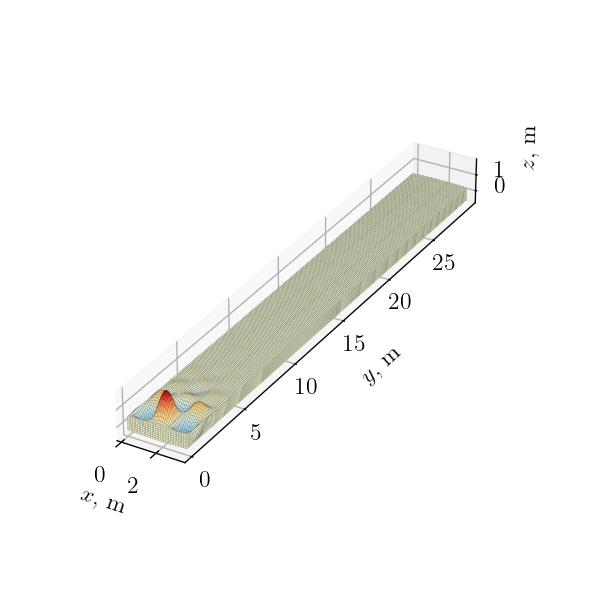

Critical buckling mode of model with flat skin:


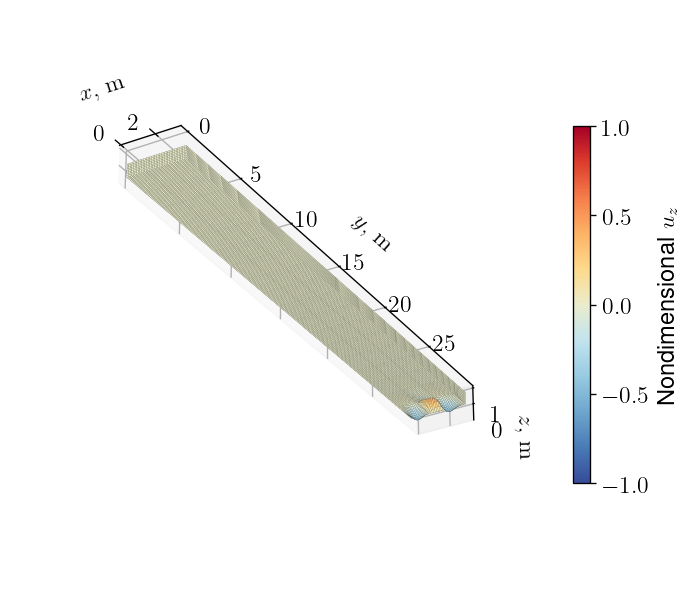

In [14]:
# Define amplification factor of displacements
amplification_factor = 1.5

# Plot critical buckling mode of model with curved skin
key = "curved skin"
print(f"Critical buckling mode of model with {key}:")
clim = [-1., 1.]
op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, "sol_105_curved_linear_opt" + '.op2')
sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/0.7)})
fig, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz', colormap='sunset',
    length_unit='m', displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3, clim=clim)

# Adjust plot and show it
cbar.remove()
adjust_3d_plot(ax, cbar)
plt.show()

# Save figure
label = key.title().replace(" ", "")  # label of figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"LinearOptBucklingMode-{label}.png"), format='png', bbox_inches=BBOX_NO_COLORBAR, pad_inches=0, dpi=500)

# Plot critical buckling mode of model with curved skin
key = "flat skin"
print(f"Critical buckling mode of model with {key}:")
op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, "sol_105_flat_linear_opt" + '.op2')
sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
fig, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz', colormap='sunset',
    length_unit='m', displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3, clim=clim)

# Adjust plot and show it
adjust_3d_plot(ax, cbar)
ax.view_init(-30, -60)
ax.tick_params(axis="y", which="major", pad=40)  # adjust position of ticks' label of y-axis
plt.show()

# Save figure
label = key.title().replace(" ", "")  # label of figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"LinearOptBucklingMode-{label}.png"), format='png', bbox_inches=BBOX_COLORBAR, pad_inches=0, dpi=500)

# Reset default sizes
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})

Comparison of nonlinear structural stability response of linearly optimized structures.

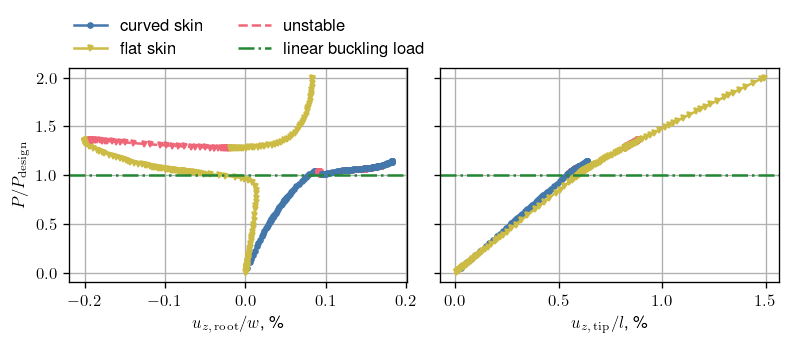

In [15]:
# Initialize dictionary with names of input files
input_name_dict = {"curved skin": "sol_106_curved_linear_opt",
                   "flat skin": "sol_106_flat_linear_opt"}

# Plot load-displacement diagrams
fig, axes, stable_lines, eigenvalues_dict, sol_106_op2_dict, nondimensional_loads_dict = plot_load_displacement_diagram(
    input_name_dict, max_nondimensional_load=2)
for ax in axes:
    linear_buckling_load_line = ax.axhline(y=1., color=COLORS[2], linestyle='-.', label="linear buckling load")

# Set plot appearance for the first subplot
axes[0].set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[1].grid(visible=True)

# Save figure
plt.tight_layout()  # Ensures proper spacing between subplots
axes[0].legend(handles=stable_lines + [unstable_line, linear_buckling_load_line], loc="upper left",
               ncols=2, bbox_to_anchor=(-.03, 1.3), frameon=False)  # add legend after tight_layout
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "LinearOptLoadDisplacementDiagram.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Compare limit point load of linearly optimized structures.

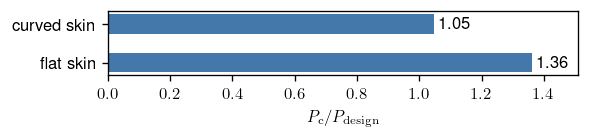


Percentage differences of limit point load of flat skin w.r.t. curved skin: 29.9%



In [16]:
# Plot bar chart with limit point loads
limit_point_loads, _ = plot_limit_point_load_bar_chart(
    ["curved skin", "flat skin"], eigenvalues_dict, nondimensional_loads_dict, "LinearOptLimitPointLoadBarChart")

# Calculate percentage differences w.r.t. distributed non-follower forces
percentage_difference = 100*(limit_point_loads[1]-limit_point_loads[0])/limit_point_loads[0]
print(f"""
Percentage differences of limit point load of flat skin w.r.t. curved skin: {percentage_difference:.1f}%
""")

Compare deformation at design load of linearly optimized structures.

Deformation of model with curved skin


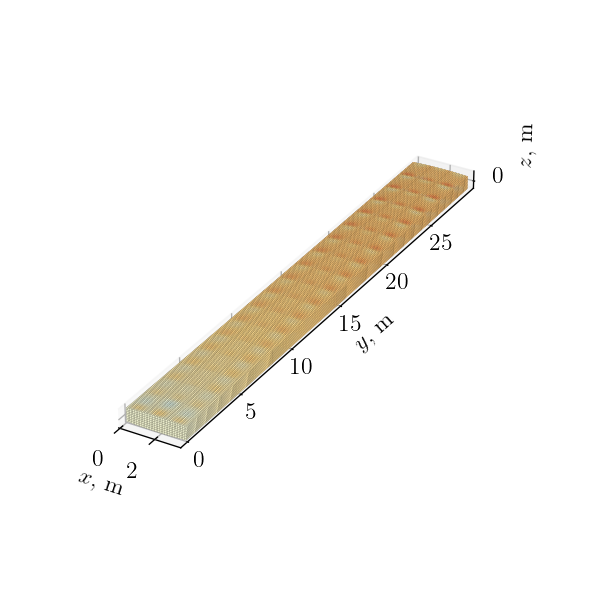

Deformation of model with flat skin


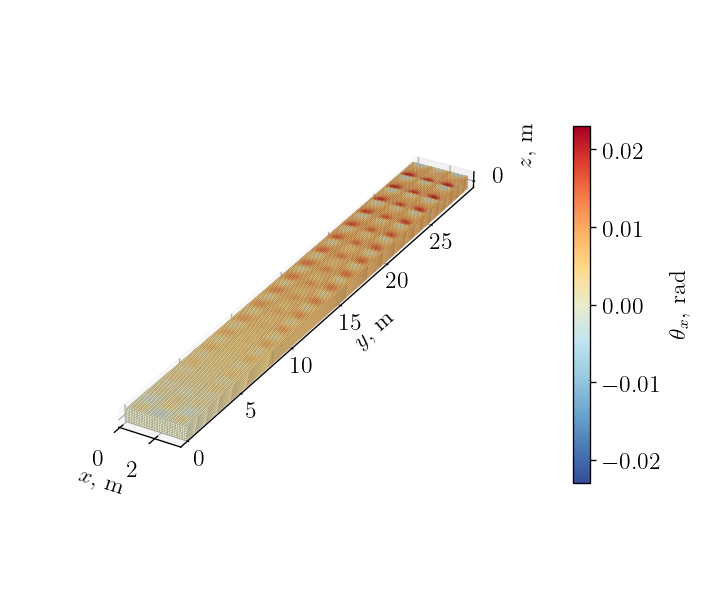

In [17]:
def plot_deformation_comparison(nondimensional_loads_dict, sol_106_op2_dict, clim, label):
    # Plot deformation of linearly optimized structure
    key = "curved skin"
    print(f"Deformation of model with {key}")
    increment_number = np.argmin(np.abs(nondimensional_loads_dict[key] - 1)) + 1  # find number of closest converged increment to design load
    plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/.7)})
    fig, ax, cbar = plot_utils.plot_deformation(
        op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=increment_number, displacement_component='rx', colormap='sunset',
        length_unit='m', unit_scale_factor=1e-3, clim=clim)
    adjust_3d_plot(ax, cbar)
    ax.set_zticks([0])
    cbar.remove()
    plt.show()
    fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"{key.replace(' ', '_')}_{label}_deformation.png"), format='png', bbox_inches=BBOX_NO_COLORBAR,
                pad_inches=0, dpi=500)

    # Plot deformation of nonlinearly optimized structure
    key = "flat skin"
    print(f"Deformation of model with {key}")
    increment_number = np.argmin(np.abs(nondimensional_loads_dict[key] - 1)) + 1  # find number of closest converged increment to design load
    fig, ax, cbar = plot_utils.plot_deformation(
        op2=sol_106_op2_dict[key], subcase_id=FIRST_SUBCASE_ID, load_step=increment_number, displacement_component='rx', colormap='sunset',
        length_unit='m', unit_scale_factor=1e-3, clim=clim)
    adjust_3d_plot(ax, cbar)
    ax.set_zticks([0])
    plt.show()
    fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"{key.replace(' ', '_')}_{label}_deformation.png"), format='png', bbox_inches=BBOX_COLORBAR,
                pad_inches=0, dpi=500)

    # Restore default font size
    plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})

# Plot deformation comparison
clim = [-.023, .023] # color limits for deformation plot
label = "linear_opt"
plot_deformation_comparison(nondimensional_loads_dict, sol_106_op2_dict, clim, label)

### Comparison of the nonlinearly optimized structures <a name="nonlinear"></a>

Plot history of optimization with curved skin.

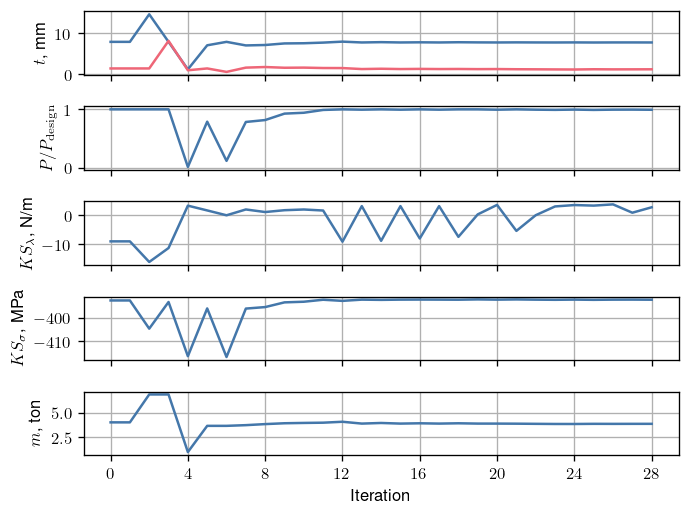

Design variables, constraints and objective at last iteration:
- interp.t_cp: [7.8 1.2]
- nastran_solver.applied_load: [1.]
- nastran_solver.ks_stability: [2.8]
- nastran_solver.ks_stress: [-392.5]
- nastran_solver.mass: [3.9]


In [18]:
recorder_filename = "sol_106_curved_nonlinear_opt.sql"
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, recorder_filename)
fig, curved_skin_nonlinear_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "CurvedSkinNonlinearOptHistory.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Print results at last feasible design.

In [19]:
curved_skin_feasible_design_index = np.where(curved_skin_nonlinear_opt_histories['nastran_solver.ks_stability'][:, 0] <= 0)[0][-1]
mass_reduction = (curved_skin_nonlinear_opt_histories['nastran_solver.mass'][curved_skin_feasible_design_index, 0]/
                  curved_skin_linear_opt_histories['nastran_solver.mass'][-1, 0] - 1)*100
feasible_thickness_array = curved_skin_nonlinear_opt_histories['interp.t_cp'][curved_skin_feasible_design_index, :]
print("Final thicknesses (mm):")
print(feasible_thickness_array)
print(f"""Final KS value of nonlinear structural stability: {
    curved_skin_nonlinear_opt_histories['nastran_solver.ks_stability'][curved_skin_feasible_design_index, 0]:.2f} N/m
Final KS value for stress: {curved_skin_nonlinear_opt_histories['nastran_solver.ks_stress'][curved_skin_feasible_design_index, 0]:.0f} MPa
Final nondimensional applied load: {curved_skin_nonlinear_opt_histories['nastran_solver.applied_load'][curved_skin_feasible_design_index, 0]:.2f}
Mass variation: {mass_reduction:.1f} %""")

Final thicknesses (mm):
[7.8 1.3]
Final KS value of nonlinear structural stability: -5.34 N/m
Final KS value for stress: -392 MPa
Final nondimensional applied load: 1.00
Mass variation: -3.3 %


Plot history of optimization with flat skin.

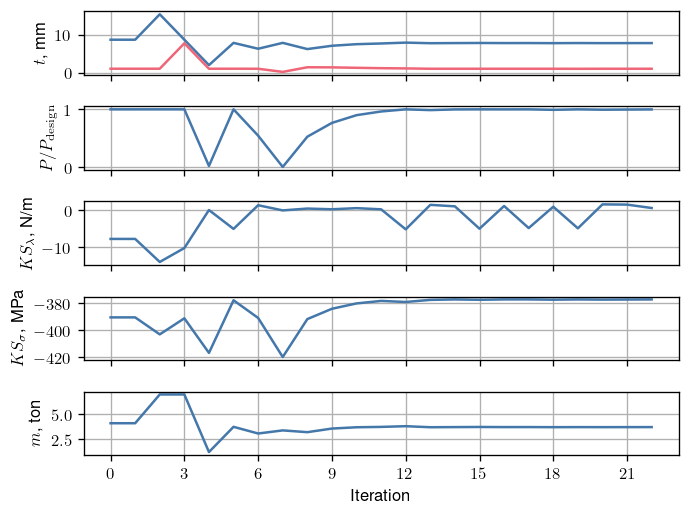

Design variables, constraints and objective at last iteration:
- interp.t_cp: [7.8 1. ]
- nastran_solver.applied_load: [1.]
- nastran_solver.ks_stability: [0.6]
- nastran_solver.ks_stress: [-377.3]
- nastran_solver.mass: [3.7]


In [20]:
recorder_filename = "sol_106_flat_nonlinear_opt.sql"
recorder_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, recorder_filename)
fig, flat_skin_nonlinear_opt_histories = optimization_utils.plot_optimization_history(recorder_filepath)  # plot optimization history
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "FlatSkinNonlinearOptHistory.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Print results at last feasible design.

In [21]:
flat_skin_feasible_design_index = np.where(flat_skin_nonlinear_opt_histories['nastran_solver.ks_stability'][:, 0] <= 0)[0][-1]
mass_reduction = (flat_skin_nonlinear_opt_histories['nastran_solver.mass'][flat_skin_feasible_design_index, 0]/
                  flat_skin_linear_opt_histories['nastran_solver.mass'][-1, 0] - 1)*100
feasible_thickness_array = flat_skin_nonlinear_opt_histories['interp.t_cp'][flat_skin_feasible_design_index, :]
print("Final thicknesses (mm):")
print(feasible_thickness_array)
print(f"""Final KS value of nonlinear structural stability: {
    flat_skin_nonlinear_opt_histories['nastran_solver.ks_stability'][flat_skin_feasible_design_index, 0]:.2f} N/m
Final KS value for stress: {flat_skin_nonlinear_opt_histories['nastran_solver.ks_stress'][flat_skin_feasible_design_index, 0]:.0f} MPa
Final nondimensional applied load: {flat_skin_nonlinear_opt_histories['nastran_solver.applied_load'][flat_skin_feasible_design_index, 0]:.2f}
Mass variation: {mass_reduction:.1f} %""")

Final thicknesses (mm):
[7.8 1. ]
Final KS value of nonlinear structural stability: -4.85 N/m
Final KS value for stress: -377 MPa
Final nondimensional applied load: 1.00
Mass variation: -9.3 %


Plot bar chat of final thicknesses.

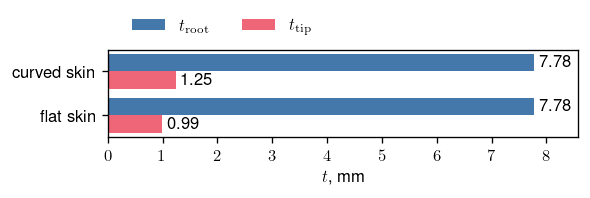

In [22]:
figure_name = "NonlinearOptThicknesses"
plot_thickness_bar_chart(curved_skin_nonlinear_opt_histories, flat_skin_nonlinear_opt_histories, figure_name,
                         iter_indices=[curved_skin_feasible_design_index, flat_skin_feasible_design_index])

Plot bar chart of final masses.

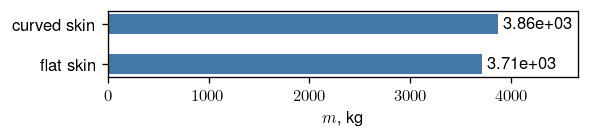

In [23]:
figure_name = "NonlinearOptMasses"
plot_final_mass_bar_chart(curved_skin_nonlinear_opt_histories, flat_skin_nonlinear_opt_histories, figure_name)

Compare linear buckling mode of nonlinearly optimized structures.

Critical buckling mode of model with curved skin:


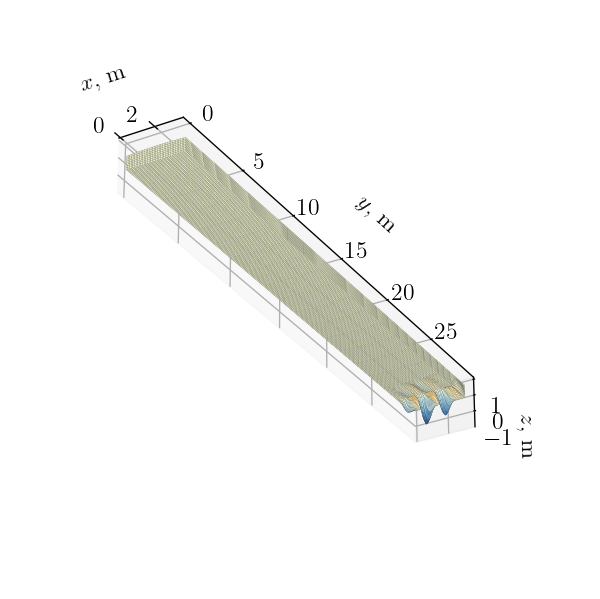

Critical buckling mode of model with flat skin:


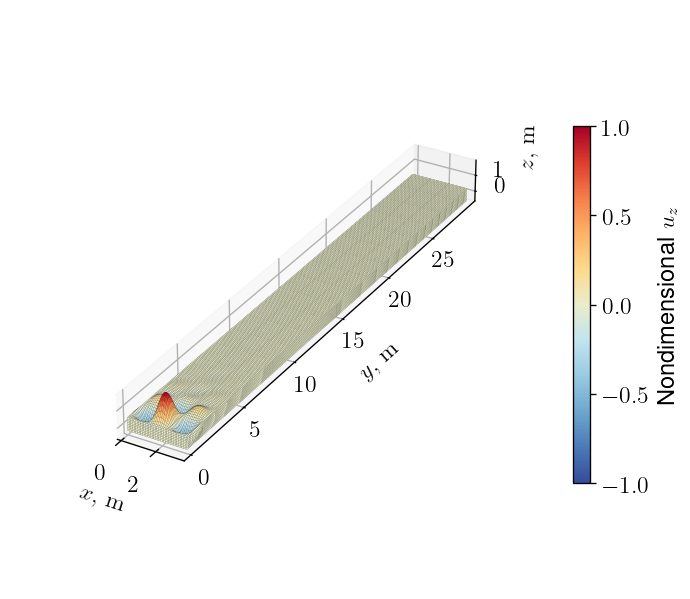

In [24]:
# Plot critical buckling mode of model with curved skin
key = "curved skin"
print(f"Critical buckling mode of model with {key}:")
clim = [-1., 1.]
op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, "sol_105_curved_nonlinear_opt" + '.op2')
sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
buckling_load_factors[0] = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE*(1/0.7)})
fig, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz', colormap='sunset',
    length_unit='m', displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3, clim=clim)

# Adjust plot and show it
cbar.remove()
adjust_3d_plot(ax, cbar)
ax.view_init(-30, -60)
ax.tick_params(axis="y", which="major", pad=40)  # adjust position of ticks' label of y-axis
plt.show()

# Save figure
label = key.title().replace(" ", "")  # label of figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"NonlinearOptBucklingMode-{label}.png"), format='png', bbox_inches=BBOX_NO_COLORBAR, pad_inches=0, dpi=500)

# Plot critical buckling mode of model with curved skin
key = "flat skin"
print(f"Critical buckling mode of model with {key}:")
op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, "sol_105_flat_nonlinear_opt" + '.op2')
sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
buckling_load_factors[1] = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
fig, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2, subcase_id=SECOND_SUBCASE_ID, displacement_component='tz', colormap='sunset',
    length_unit='m', displacement_amplification_factor=amplification_factor, unit_scale_factor=1e-3, clim=clim)

# Adjust plot and show
adjust_3d_plot(ax, cbar)
plt.show()

# Save figure
label = key.title().replace(" ", "")  # label of figure
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, f"NonlinearOptBucklingMode-{label}.png"), format='png', bbox_inches=BBOX_COLORBAR, pad_inches=0, dpi=500)

# Reset default sizes
plt.rcParams.update({'font.size': DEFAULT_FONT_SIZE})

Comparison of nonlinear structural stability response of nonlinearly optimized structures.

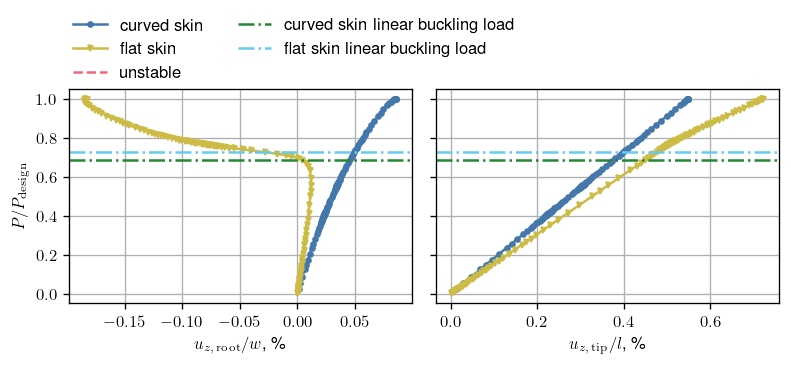

In [25]:
# Initialize dictionary with names of input files
input_name_dict = {"curved skin": "sol_106_curved_nonlinear_opt",
                   "flat skin": "sol_106_flat_nonlinear_opt"}

# Plot load-displacement diagrams
fig, axes, stable_lines, eigenvalues_dict, sol_106_op2_dict, nondimensional_loads_dict = plot_load_displacement_diagram(
    input_name_dict)

# Plot linear buckling load lines
linear_buckling_load_lines = [Line2D([0], [0])]*2
for count, key in enumerate(input_name_dict):
    for ax in axes:
        linear_buckling_load_lines[count] = ax.axhline(y=buckling_load_factors[count], color=COLORS[2 + count], linestyle='-.',
                                                       label=f"{key} linear buckling load")

# Create proxy artists for unstable segments
unstable_line = Line2D([0], [0], linestyle='--', color=UNSTABLE_COLOR, label="unstable")

# Set plot appearance for the first subplot
axes[0].set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
axes[0].set_ylabel("$P/P_\mathrm{design}$")
axes[0].grid(visible=True)

# Set plot appearance for the second subplot
axes[1].set_xlabel("$u_{z,\,\mathrm{tip}}/l$, \%")
axes[1].grid(visible=True)

# Save figure
plt.tight_layout()  # Ensures proper spacing between subplots
axes[0].legend(handles=stable_lines + [unstable_line] + linear_buckling_load_lines, loc="upper left",
               ncols=2, bbox_to_anchor=(-.03, 1.4), frameon=False)  # add legend after tight_layout
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "NonlinearOptLoadDisplacementDiagram.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Compare deformation at design load of nonlinearly optimized structures.

Deformation of model with curved skin


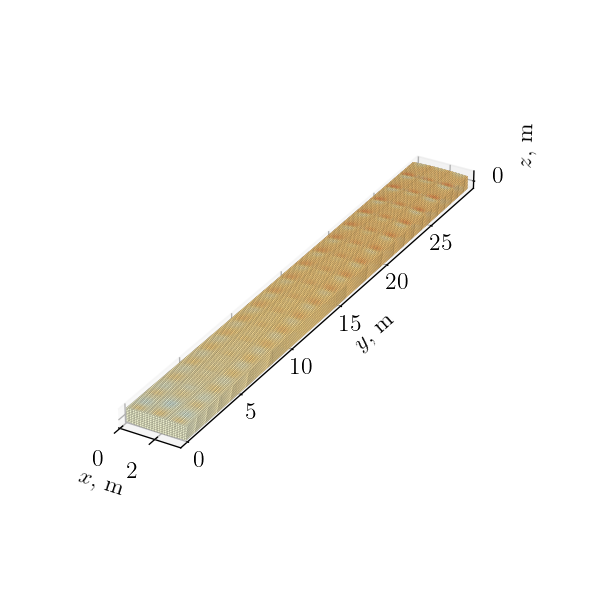

Deformation of model with flat skin


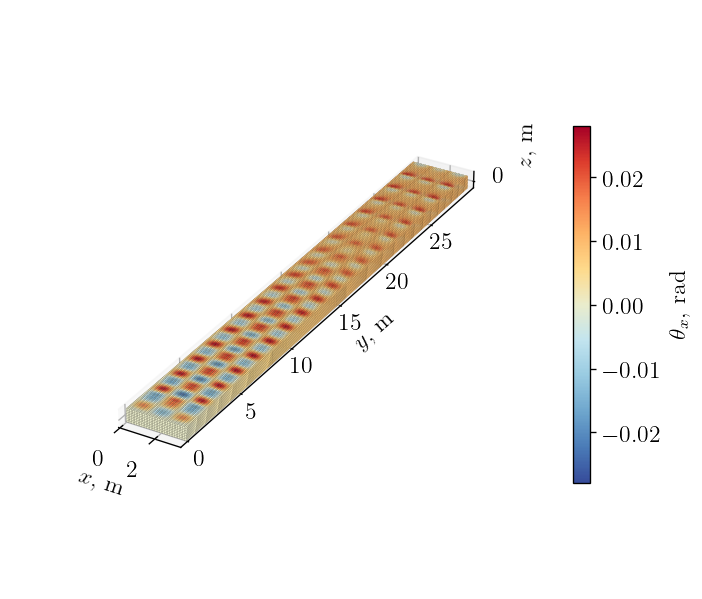

In [26]:
clim = [-.028, .028]  # color limits for deformation plot
label = "nonlinear_opt"
plot_deformation_comparison(nondimensional_loads_dict, sol_106_op2_dict, clim, label)

## Appendix <a name="appendix"></a>

***

Plot mesh convergence study.

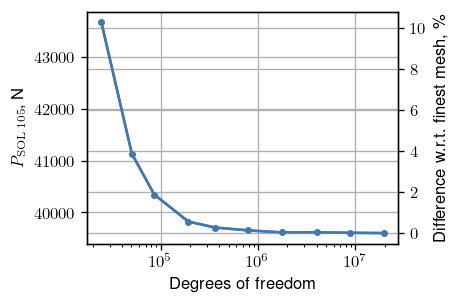

In [27]:
# Define additional geometric parameters
h_a = H/15  # maximum arch height [mm]
no_stiffeners = 2  # number of stiffeners
h_s = H/10  # height of stiffeners [mm]
stiffeners_x_locations = np.linspace(0, W, no_stiffeners + 2)[1:-1]  # [mm] stiffeners x-coordinates
stiffeners_spacing = W/(no_stiffeners + 1)  # [mm] stiffeners spacing
ribs_spacing = stiffeners_spacing*1.4 # [mm] ribs spacing
no_ribs = round(L/ribs_spacing) + 1  # number of ribs
ribs_y_locations = np.linspace(0, L, no_ribs)  # [mm] ribs y-coordinates

# Define shell elements lengths to be used for the mesh convergence study
shell_element_lengths = np.geomspace(H/2, h_s/8, 10) # [mm]

# Initialize arrays with number of elements, number of degrees of freedom and linear buckling loads
dofs = np.empty(np.shape(shell_element_lengths), dtype=int)
linear_buckling_loads = np.empty(np.shape(shell_element_lengths))

# Iterate through the different target element lengths
for count, element_length in enumerate(shell_element_lengths):
    # Generate mesh
    mesh = box_beam_utils.mesh_reinforced_box_beam_with_curved_skins(
        width=W, height=H, arc_height=h_a, ribs_y_coordinates=ribs_y_locations, stiffeners_x_coordinates=stiffeners_x_locations,
        stiffeners_height=h_s, element_length=element_length)
    nodes_connectivity_matrix = mesh.faces.reshape(-1, 5)[:, 1:]
    
    # Read op2 file
    input_name = f"sol_105_{len(nodes_connectivity_matrix)}_elements"
    op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, input_name + '.op2')
    sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
    
    # Find number of degrees of freedom and critical buckling load
    constrained_nodes_ids = next(iter(sol_105_op2.spcs.values()))[0].node_ids
    dofs[count] = (len(sol_105_op2.nodes) - len(constrained_nodes_ids))*6
    linear_buckling_loads[count] = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].eigrs[0]
    
# Plot buckling loads vs degrees of freedom with a log scale along the x-axis
fig, ax1 = plt.subplots(figsize=(FIG_WIDTH_INCHES, FIG_HEIGHT_INCHES))  # create a figure and set of axes
buckling_load_line = ax1.semilogx(dofs, linear_buckling_loads, 'o-')

# Create a twin set of axes to plot percentage difference vs degrees of freedom
ax2 = ax1.twinx()
percentage_diff = (linear_buckling_loads/linear_buckling_loads[-1]-1)*100
percentage_diff_line = ax2.plot(dofs, percentage_diff, 'o-')

# Set axes labels and grid
ax1.set_xlabel("Degrees of freedom")
ax1.set_ylabel("$P_\mathrm{SOL\,105}$, N")
ax2.set_ylabel("Difference w.r.t. finest mesh, \%")
ax1.grid(True)
ax2.grid(True)

# Show plot and save figure
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "MeshConvergence.svg"), format='svg', bbox_inches='tight', pad_inches=0)

Plot mesh convergence verification.

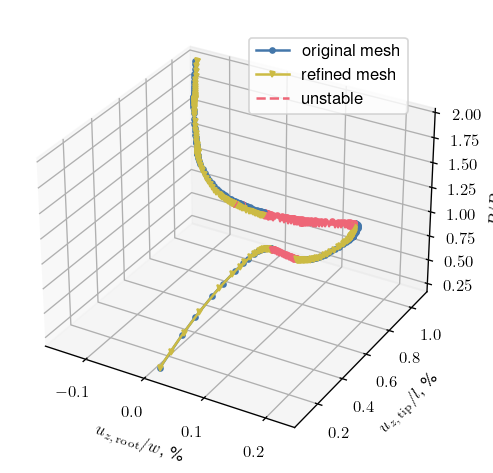

In [28]:
# Define dictionary with names of input files
input_name_dict = {"original mesh": "33120_elements",
                   "refined mesh": "108276_elements"}

# Initialize dictionaries to store ids of nodes where max displacement occurs and tip nodes
root_node_id_dict = {}  # dictionary to store ids of nodes where max displacement occurs
tip_node_id_dict = {}  # dictionary to store ids of tip nodes

# Create 3D plot of equilibrium diagram
fig = plt.figure()  # create a figure
ax_3d = plt.axes(projection="3d")  # create 3D axes
stable_lines = []  # list to store proxy artists for the legend

# Iterate over the different meshes
for count, key in enumerate(input_name_dict):
    # Read op2 file of linear buckling analysis
    op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, f"sol_105_{input_name_dict[key]}.op2")
    sol_105_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)

    # Find node where max displacement occurs
    max_displacement_index = np.argmax(np.linalg.norm(sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].data[0, :, 0:3], axis=1))  # find index of max displacement magnitude
    root_node_id_dict[key] = sol_105_op2.eigenvectors[SECOND_SUBCASE_ID].node_gridtype[max_displacement_index, 0]  # find id of node with max displacement magnitude
    
    # Find tip node id
    nodes_xyz_array = np.array([node.xyz for node in sol_105_op2.nodes.values()])  # get nodes' coordinates
    tip_node_id_dict[key] = np.argmin(np.linalg.norm(nodes_xyz_array - tip_node_xyz, axis=1)) + 1  # find id of tip node

    # Read op2 file of nonlinear analysis
    op2_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, f"sol_106_{input_name_dict[key]}.op2")
    sol_106_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
    
    # Read load-displacement history
    _, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_op2, node_ids=[root_node_id_dict[key], tip_node_id_dict[key]])
    
    # Read eigenvalues
    f06_filepath = os.path.join(ANALYSIS_DIRECTORY_PATH, f"sol_106_{input_name_dict[key]}.f06")  # path of f06 file
    eigenvalues = pynastran_utils.read_kllrh_lowest_eigenvalues_from_f06(f06_filepath)  # read eigenvalues from f06 file

    # Nondimensionalize loads and displacements
    nondimensional_loads = loads[FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/design_load
    nondimensional_displacements = {"root": displacements[root_node_id_dict[key]][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/W,
                                    "tip": displacements[tip_node_id_dict[key]][FIRST_SUBCASE_ID][:, Z_COMPONENT_INDEX]/L}

    # Plot load-displacement curve
    plot_utils.plot_3d_load_displacements_stability(axes=ax_3d,
                                                    displacements1=nondimensional_displacements["root"]*100,
                                                    displacements2=nondimensional_displacements["tip"]*100,
                                                    loads=nondimensional_loads,
                                                    eigenvalues=eigenvalues,
                                                    marker=MARKERS[count], color=COLORS[count])
    stable_lines.append(Line2D([0], [0], linestyle='-', marker=MARKERS[count], color=COLORS[count], label=key))  # create proxy artist for the legend

# Add proxy artist for unstable lines and create legend
fig.legend(handles=stable_lines + [unstable_line], bbox_to_anchor=(0.75, 0.85))

# Set axes labels and grid
ax_3d.set_xlabel("$u_{z,\,\mathrm{root}}/w$, \%")
ax_3d.set_ylabel("$u_{z,\,\mathrm{tip}}/l$, \%")
ax_3d.set_zlabel("$P/P_\mathrm{design}$")
ax_3d.grid(visible=True)

# Show plot and save figure
plt.show()
fig.savefig(os.path.join(FIGURES_DIRECTORY_PATH, "MeshConvergenceVerification.svg"), format='svg', bbox_inches='tight', pad_inches=0)